In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import lz4.frame as lz4f
import cloudpickle as cpkl
import json
import re
import os

import uproot
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot, export

In [2]:
import sys
print(sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [3]:
with lz4f.open("hists.cpkl.lz4") as fin:
    hists_unmapped = cpkl.load(fin)

In [4]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = ("dataset")

process_map = OrderedDict()
process_map["QCD"] = [
    "QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8",
]

hists = {}

for key, val in hists_unmapped.items():
    if isinstance(val, hist.Hist):
        hists[key] = val.group(process, process_cats, process_map)

In [8]:
histo = hists['ddtmaping_preselection'].sum('AK8Puppijet0_isHadronicV', overflow='all')
val_QCD = histo.values(overflow='allnan')[('QCD',)]
qcd_maxval_temp = np.cumsum(val_QCD, axis=2)
qcd_maxval = qcd_maxval_temp[:,:,-1]

norma = qcd_maxval_temp / np.maximum(1e-10,qcd_maxval[:,:,np.newaxis])
print(norma)

[[[0.0000000e+00 4.9466431e-02 4.9692929e-02 ... 9.2277956e-01
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 1.6240858e-05 4.7660800e-05 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 1.5270312e-05 1.5270312e-05 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 5.7881583e-02 5.8145937e-02 ... 9.7975183e-01
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000

In [9]:
hist_y_QCD = histo.sum("process")
print(hist_y_QCD)
template = hist_y_QCD.sum("AK8Puppijet0_N2sdb1")
print(template)
hist_y_QCD.clear()
hist_y_QCD._sumw = {():norma}

<Hist (AK8Puppijet0_pt,ak8jet_rho,AK8Puppijet0_N2sdb1) instance at 0x7f424a34af98>
<Hist (AK8Puppijet0_pt,ak8jet_rho) instance at 0x7f424a34ae48>


In [24]:
import scipy.ndimage as sc
res = np.apply_along_axis(lambda norma: norma.searchsorted(0.26), axis = 2, arr = norma)
print(res.shape)
res[res>100]=0
print(hist_y_QCD.identifiers("AK8Puppijet0_N2sdb1"))
def bineval(a):
    return hist_y_QCD.identifiers("AK8Puppijet0_N2sdb1")[a].lo
print(bineval(55))
binfunc = np.vectorize(bineval)
qmap = binfunc(res)
print(qmap.shape)
smooth_qmap = sc.filters.gaussian_filter(qmap,1)

(103, 55)
[<Interval ([0, 0.005)) instance at 0x7f424a341f28>, <Interval ([0.005, 0.01)) instance at 0x7f424a341f60>, <Interval ([0.01, 0.015)) instance at 0x7f424a341f98>, <Interval ([0.015, 0.02)) instance at 0x7f424a341fd0>, <Interval ([0.02, 0.025)) instance at 0x7f424a346048>, <Interval ([0.025, 0.03)) instance at 0x7f424a346080>, <Interval ([0.03, 0.035)) instance at 0x7f424a3460b8>, <Interval ([0.035, 0.04)) instance at 0x7f424a3460f0>, <Interval ([0.04, 0.045)) instance at 0x7f424a346128>, <Interval ([0.045, 0.05)) instance at 0x7f424a346160>, <Interval ([0.05, 0.055)) instance at 0x7f424a346198>, <Interval ([0.055, 0.06)) instance at 0x7f424a3461d0>, <Interval ([0.06, 0.065)) instance at 0x7f424a346208>, <Interval ([0.065, 0.07)) instance at 0x7f424a346240>, <Interval ([0.07, 0.075)) instance at 0x7f424a346278>, <Interval ([0.075, 0.08)) instance at 0x7f424a3462b0>, <Interval ([0.08, 0.085)) instance at 0x7f424a3462e8>, <Interval ([0.085, 0.09)) instance at 0x7f424a346320>, <I

In [29]:
template.clear()
template._sumw = {():qmap}
template.label = 'N2 cut at 26%'

values_nonan = template.values()[()]
print(template)

print(values_nonan)

<Hist (AK8Puppijet0_pt,ak8jet_rho) instance at 0x7f424a34ae48>
[[0.34  0.335 0.335 ... 0.28  0.275 0.27 ]
 [0.335 0.335 0.335 ... 0.275 0.275 0.27 ]
 [0.335 0.33  0.33  ... 0.275 0.27  0.27 ]
 ...
 [0.235 0.235 0.23  ... 0.17  0.185 0.185]
 [0.24  0.205 0.24  ... 0.19  0.185 0.18 ]
 [0.24  0.24  0.225 ... 0.19  0.18  0.175]]


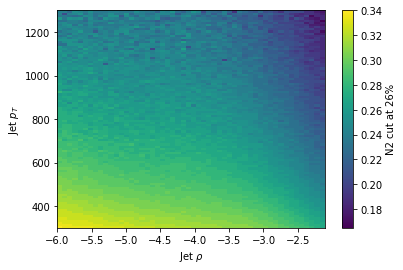

In [30]:
fig3, ax3, _ = plot.plot2d(template, xaxis="ak8jet_rho", patch_opts={})

fig3.savefig("plots/N2DDT_26_2018bits_NoSmoothing.pdf")
fig3.savefig("plots/N2DDT_26_2018bits_NoSmoothing.png")
fig3.savefig("plots/N2DDT_26_2018bits_NoSmoothing.svg")

In [ ]:
import ROOT
outfile = ROOT.TFile("plots/n2ddtmap_2018bits_Gaussian1Sigma.root","recreate")
outfile.cd()
print(values_nonan.shape)
h1 = ROOT.TH2F("h1","h1",52, -6, -2.1, 50, 0., 1.)
for i in range(h1.GetNbinsX()):
    for j in range(h1.GetNbinsY()):
        print(i,"i coord",j,"j coord",values_nonan[j][i])
        h1.SetBinContent(i+1,j+1,values_nonan[j][i])
        print(h1.GetBinContent(i,j))
h1.Write()
outfile.Close()